In [1]:
notebook_mode = True
viz_mode = True

In [2]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.mst_reader import MSTReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

In [3]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

# Load configurations

In [21]:
config_path = "configs/mst20.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/mst20.json:
{'expt_name': 'mst20', 'gpu_id': '0', 'train_filepath': './data/MST20_Euclidean_train.txt', 'val_filepath': './data/MST20_Euclidean_val.txt', 'test_filepath': './data/MST20_Euclidean_test.txt', 'num_nodes': 20, 'num_neighbors': -1, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 100, 'val_every': 10, 'test_every': 25, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


# Configure GPU options

In [22]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)  

In [23]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA available, using GPU ID 0


# Test data loading

Number of batches of size 10: 1000
mst_len: [3.49044772 3.35234404 3.1367952  2.70397159 2.88424293 3.57194238
 3.01600763 2.88203295 3.04222721 3.11899963]


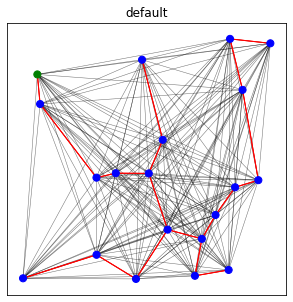

In [24]:
if notebook_mode:
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = 10
    train_filepath = config.train_filepath
    dataset = MSTReader(num_nodes, num_neighbors, batch_size, train_filepath)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    batch = next(iter(dataset))  # Generate a batch of MSTs

    #print("edges:", batch.edges.shape)
    #print("edges_values:", batch.edges_values.shape)
    #print("edges_targets:", batch.edges_target.shape)
    #print("nodes:", batch.nodes.shape)
    #print("nodes_target:", batch.nodes_target.shape)
    #print("nodes_coord:", batch.nodes_coord.shape)
    #print("mst_edges:", batch.mst_edges.shape)
    print("mst_len:", batch.mst_len)

    idx = 0
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_tsp(a, batch.nodes_coord[idx], batch.edges[idx], batch.edges_values[idx], batch.edges_target[idx])
    #plot_tsp_heatmap()

# Instantiate model

In [25]:
if notebook_mode:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    #print(net)

    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


# Load saved checkpoint

In [26]:
if notebook_mode==True:
    # Load checkpoint
    log_dir = f"./logs/{config.expt_name}/"
    if torch.cuda.is_available():
        checkpoint = torch.load(log_dir+"last_train_checkpoint.tar")
    else:
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
    # Load network state
    net.load_state_dict(checkpoint['model_state_dict'])
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Load other training parameters
    epoch = checkpoint['epoch']
    #train_loss = checkpoint['train_loss']
    #val_loss = checkpoint['val_loss']
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    print(f"Loaded checkpoint from epoch {epoch}")

Loaded checkpoint from epoch 99


# Visualize model predictions

Node Pairs:  29 [[2, 12], [10, 13], [0, 14], [1, 11], [17, 19], [5, 18], [0, 12], [10, 16], [15, 16], [1, 5], [8, 18], [3, 9], [6, 7], [8, 9], [14, 15], [15, 18], [4, 5], [10, 15], [4, 14], [9, 17], [0, 2], [8, 15], [3, 8], [7, 19], [0, 4], [2, 4], [3, 17], [1, 18], [9, 19]]


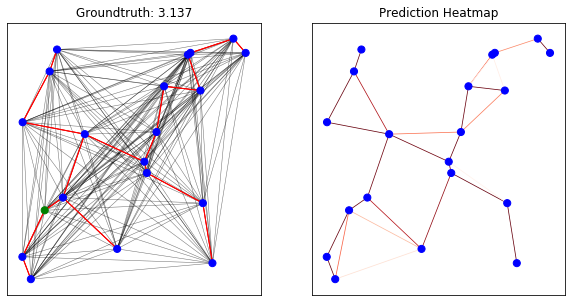

Node Pairs:  26 [[1, 5], [10, 18], [3, 19], [9, 12], [4, 13], [2, 11], [7, 8], [6, 14], [13, 17], [3, 12], [5, 7], [0, 16], [0, 14], [2, 12], [17, 18], [6, 15], [4, 15], [9, 17], [6, 8], [4, 6], [16, 17], [9, 13], [8, 14], [2, 15], [12, 19], [13, 15]]


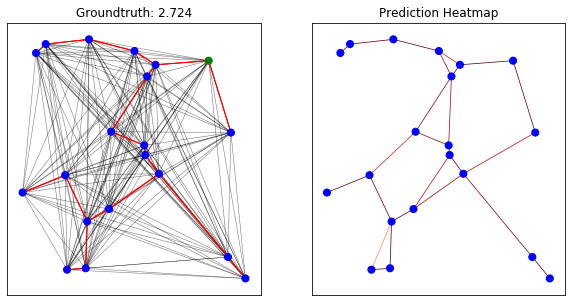

Node Pairs:  28 [[5, 19], [12, 14], [0, 17], [10, 15], [4, 11], [2, 9], [3, 13], [2, 18], [1, 13], [14, 16], [7, 8], [16, 18], [3, 15], [3, 8], [0, 4], [9, 11], [4, 6], [15, 17], [2, 19], [7, 16], [10, 17], [13, 15], [9, 19], [3, 17], [5, 14], [2, 11], [7, 18], [4, 17]]


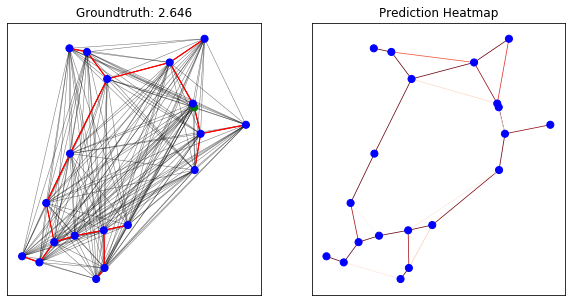

Node Pairs:  34 [[3, 4], [13, 18], [8, 15], [10, 14], [12, 17], [1, 11], [9, 17], [2, 19], [7, 19], [2, 9], [0, 15], [12, 13], [3, 8], [11, 19], [10, 13], [5, 7], [6, 11], [16, 17], [0, 14], [10, 15], [6, 12], [13, 14], [6, 9], [4, 8], [2, 16], [14, 15], [9, 12], [5, 19], [9, 19], [2, 5], [1, 7], [3, 15], [5, 16], [14, 17]]


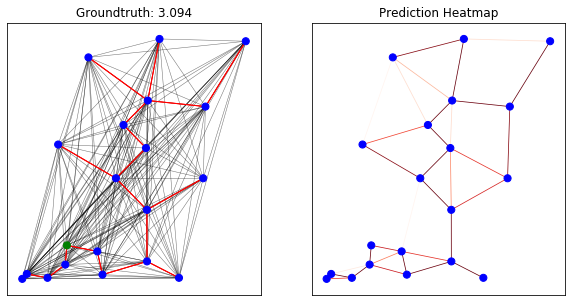

Node Pairs:  32 [[8, 19], [3, 15], [9, 13], [0, 4], [9, 10], [5, 16], [12, 14], [6, 13], [11, 14], [4, 16], [7, 15], [11, 15], [1, 10], [1, 19], [5, 17], [2, 18], [3, 17], [4, 5], [2, 3], [8, 18], [2, 10], [2, 8], [7, 17], [3, 18], [7, 12], [10, 17], [5, 7], [3, 10], [0, 5], [14, 15], [1, 8], [1, 9]]


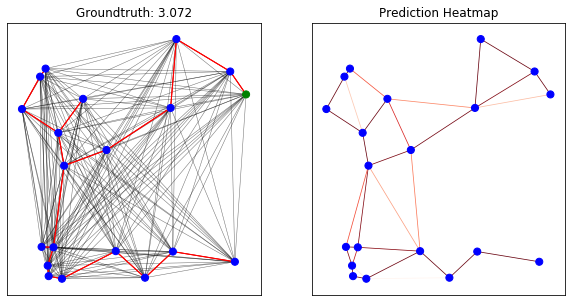

Node Pairs:  28 [[10, 13], [0, 12], [2, 7], [4, 19], [0, 18], [7, 16], [3, 10], [15, 17], [5, 18], [8, 19], [14, 16], [1, 6], [9, 17], [8, 17], [7, 15], [9, 12], [5, 13], [3, 6], [11, 12], [6, 19], [6, 8], [11, 13], [2, 15], [0, 9], [0, 11], [2, 16], [5, 11], [9, 15]]


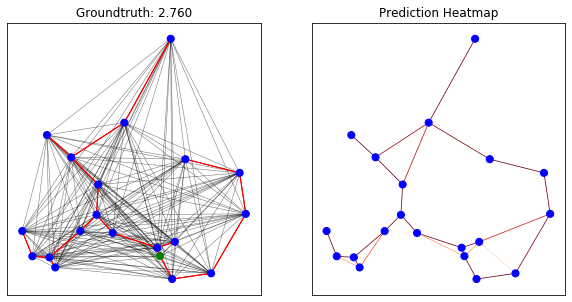

Node Pairs:  29 [[14, 16], [2, 9], [0, 10], [5, 13], [3, 4], [5, 12], [7, 17], [11, 16], [1, 15], [6, 19], [8, 17], [9, 18], [3, 7], [5, 19], [6, 15], [11, 17], [2, 3], [10, 19], [15, 18], [0, 11], [13, 16], [18, 19], [0, 7], [10, 18], [0, 17], [4, 7], [13, 19], [6, 18], [10, 11]]


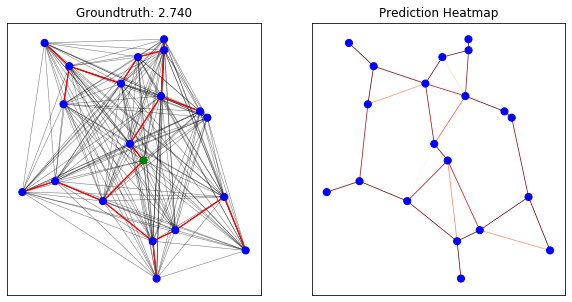

Node Pairs:  26 [[10, 15], [13, 17], [0, 12], [8, 14], [9, 19], [10, 13], [3, 8], [4, 5], [3, 16], [5, 18], [1, 19], [11, 18], [2, 16], [14, 17], [2, 7], [7, 11], [6, 16], [7, 9], [2, 3], [5, 17], [0, 1], [11, 17], [13, 15], [17, 18], [3, 7], [1, 12]]


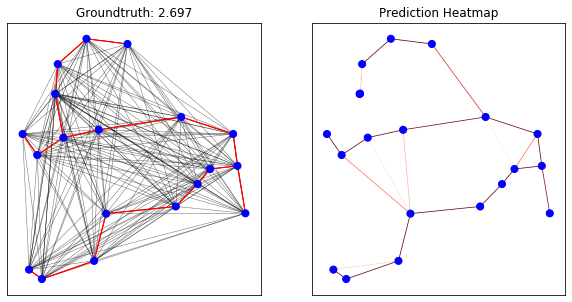

Node Pairs:  27 [[2, 16], [6, 12], [0, 13], [6, 10], [0, 14], [9, 18], [11, 19], [9, 17], [5, 8], [7, 14], [4, 13], [15, 19], [10, 11], [8, 17], [3, 18], [7, 15], [9, 11], [4, 16], [4, 19], [4, 10], [1, 11], [1, 3], [8, 12], [1, 9], [11, 17], [10, 19], [6, 16]]


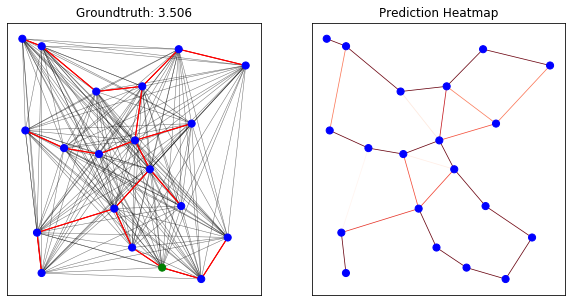

Node Pairs:  32 [[4, 11], [10, 16], [5, 14], [6, 9], [8, 19], [3, 7], [16, 18], [11, 15], [6, 7], [1, 12], [2, 17], [13, 19], [2, 19], [1, 15], [0, 18], [8, 18], [2, 15], [1, 11], [3, 17], [2, 12], [17, 19], [0, 16], [3, 14], [3, 8], [5, 6], [4, 15], [13, 18], [12, 17], [3, 5], [12, 15], [7, 9], [10, 18]]


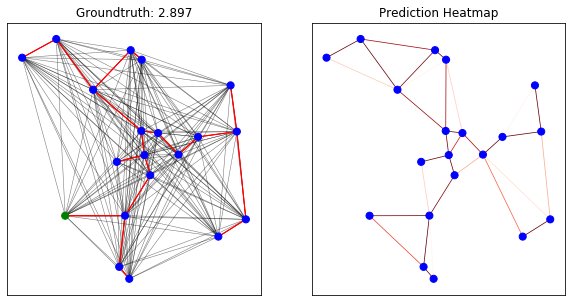

In [28]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 10
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    beam_size = 2
    test_filepath = config.test_filepath
    dataset = iter(MSTReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)

    with torch.no_grad():
        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        #print("Class weights: {}".format(edge_cw))
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()
        #print("EDGE VALUE SHAPE: ", x_edges_values.shape)
        plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=batch_size)

Node Pairs:  28 [[10, 13], [0, 12], [2, 7], [4, 19], [0, 18], [7, 16], [3, 10], [15, 17], [5, 18], [8, 19], [14, 16], [1, 6], [9, 17], [8, 17], [7, 15], [9, 12], [5, 13], [3, 6], [11, 12], [6, 19], [6, 8], [11, 13], [2, 15], [0, 9], [0, 11], [2, 16], [5, 11], [9, 15]]


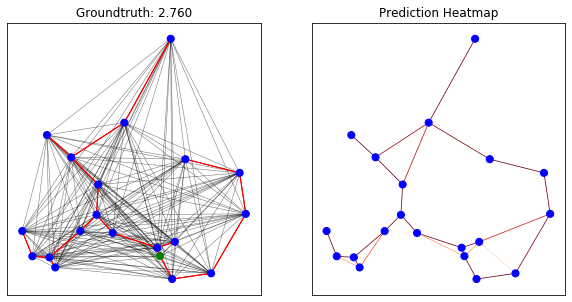

Node Pairs:  28 [[5, 19], [12, 14], [0, 17], [10, 15], [4, 11], [2, 9], [3, 13], [2, 18], [1, 13], [14, 16], [7, 8], [16, 18], [3, 15], [3, 8], [0, 4], [9, 11], [4, 6], [15, 17], [2, 19], [7, 16], [10, 17], [13, 15], [9, 19], [3, 17], [5, 14], [2, 11], [7, 18], [4, 17]]


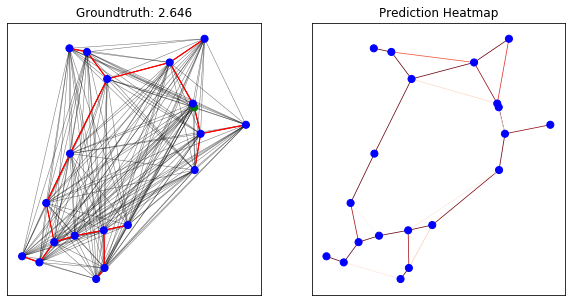

Node Pairs:  29 [[2, 12], [10, 13], [0, 14], [1, 11], [17, 19], [5, 18], [0, 12], [10, 16], [15, 16], [1, 5], [8, 18], [3, 9], [6, 7], [8, 9], [14, 15], [15, 18], [4, 5], [10, 15], [4, 14], [9, 17], [0, 2], [8, 15], [3, 8], [7, 19], [0, 4], [2, 4], [3, 17], [1, 18], [9, 19]]


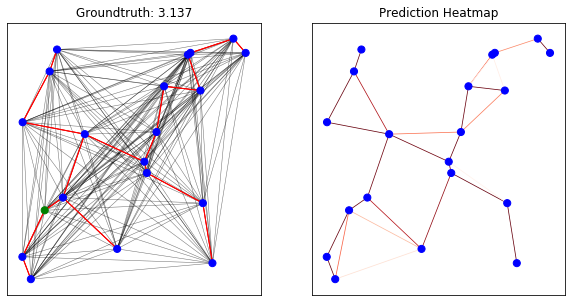

Node Pairs:  27 [[2, 16], [6, 12], [0, 13], [6, 10], [0, 14], [9, 18], [11, 19], [9, 17], [5, 8], [7, 14], [4, 13], [15, 19], [10, 11], [8, 17], [3, 18], [7, 15], [9, 11], [4, 16], [4, 19], [4, 10], [1, 11], [1, 3], [8, 12], [1, 9], [11, 17], [10, 19], [6, 16]]


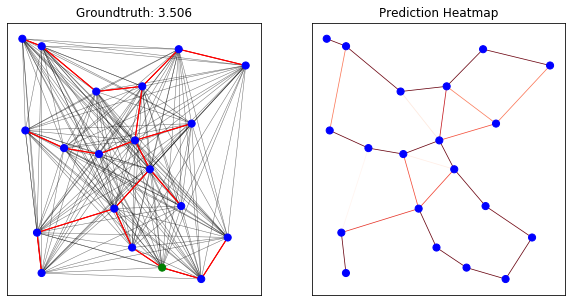

Node Pairs:  32 [[8, 19], [3, 15], [9, 13], [0, 4], [9, 10], [5, 16], [12, 14], [6, 13], [11, 14], [4, 16], [7, 15], [11, 15], [1, 10], [1, 19], [5, 17], [2, 18], [3, 17], [4, 5], [2, 3], [8, 18], [2, 10], [2, 8], [7, 17], [3, 18], [7, 12], [10, 17], [5, 7], [3, 10], [0, 5], [14, 15], [1, 8], [1, 9]]


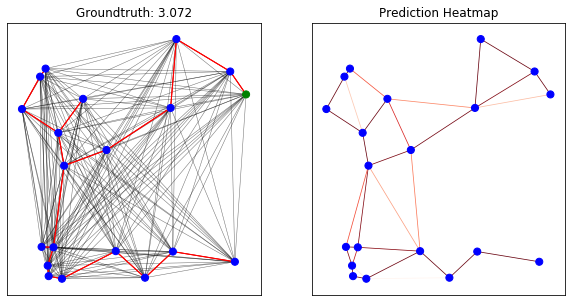

Node Pairs:  26 [[1, 5], [10, 18], [3, 19], [9, 12], [4, 13], [2, 11], [7, 8], [6, 14], [13, 17], [3, 12], [5, 7], [0, 16], [0, 14], [2, 12], [17, 18], [6, 15], [4, 15], [9, 17], [6, 8], [4, 6], [16, 17], [9, 13], [8, 14], [2, 15], [12, 19], [13, 15]]


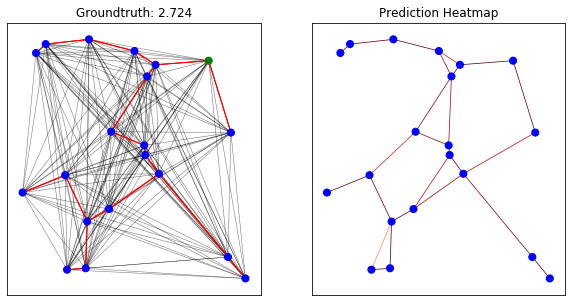

Node Pairs:  32 [[4, 11], [10, 16], [5, 14], [6, 9], [8, 19], [3, 7], [16, 18], [11, 15], [6, 7], [1, 12], [2, 17], [13, 19], [2, 19], [1, 15], [0, 18], [8, 18], [2, 15], [1, 11], [3, 17], [2, 12], [17, 19], [0, 16], [3, 14], [3, 8], [5, 6], [4, 15], [13, 18], [12, 17], [3, 5], [12, 15], [7, 9], [10, 18]]


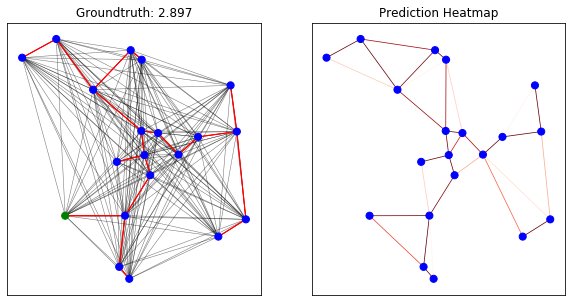

Node Pairs:  29 [[14, 16], [2, 9], [0, 10], [5, 13], [3, 4], [5, 12], [7, 17], [11, 16], [1, 15], [6, 19], [8, 17], [9, 18], [3, 7], [5, 19], [6, 15], [11, 17], [2, 3], [10, 19], [15, 18], [0, 11], [13, 16], [18, 19], [0, 7], [10, 18], [0, 17], [4, 7], [13, 19], [6, 18], [10, 11]]


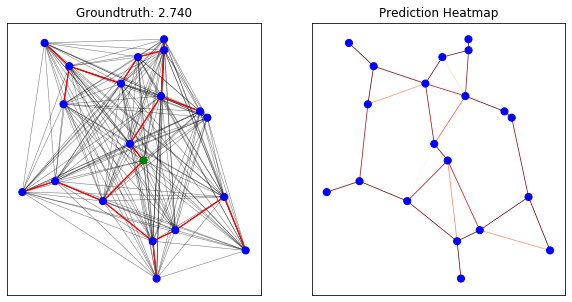

Node Pairs:  26 [[10, 15], [13, 17], [0, 12], [8, 14], [9, 19], [10, 13], [3, 8], [4, 5], [3, 16], [5, 18], [1, 19], [11, 18], [2, 16], [14, 17], [2, 7], [7, 11], [6, 16], [7, 9], [2, 3], [5, 17], [0, 1], [11, 17], [13, 15], [17, 18], [3, 7], [1, 12]]


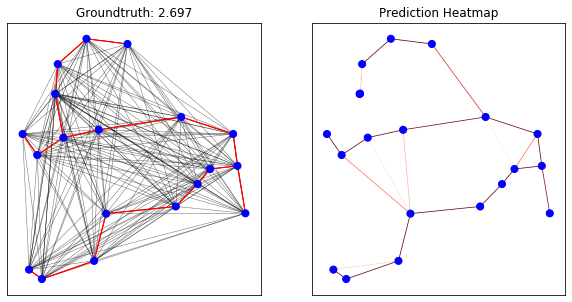

Node Pairs:  34 [[3, 4], [13, 18], [8, 15], [10, 14], [12, 17], [1, 11], [9, 17], [2, 19], [7, 19], [2, 9], [0, 15], [12, 13], [3, 8], [11, 19], [10, 13], [5, 7], [6, 11], [16, 17], [0, 14], [10, 15], [6, 12], [13, 14], [6, 9], [4, 8], [2, 16], [14, 15], [9, 12], [5, 19], [9, 19], [2, 5], [1, 7], [3, 15], [5, 16], [14, 17]]


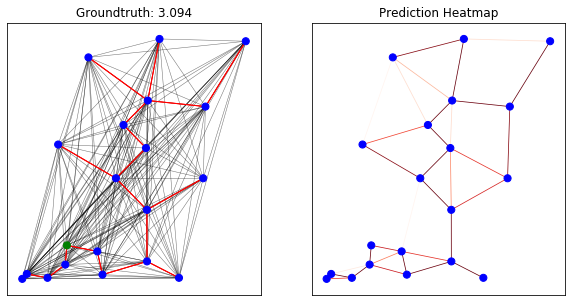

In [29]:
plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=batch_size)

`data = {'inputs': graph_inputs,
 'solutions': graph_edges,
 'rewards': graph_rewards,
 'num_nodes': num_nodes,
 'num_graphs': num_graphs}

     
dict_keys(['inputs','rewards', 'num_nodes', 'num_graphs'])
['inf,0.2994,0.5053,0.5887,0.7283,0.2994,inf,0.3406,0.2939,0.669,0.5053,0.3406,inf,0.3271,0.3515,0.5887,0.2939,0.3271,inf,0.6656,0.7283,0.669,0.3515,0.6656,inf', 'inf,0.8375,0.5197,0.3994,0.727,0.8375,inf,0.6713,0.4912,0.1108,0.5197,0.6713,inf,0.2723,0.5938,0.3994,0.4912,0.2723,inf,0.3904,0.727,0.1108,0.5938,0.3904,inf', 'inf,0.5947,0.4432,0.314,0.3974,0.5947,inf,0.4782,0.8733,0.5608,0.4432,0.4782,inf,0.7476,0.7201,0.314,0.8733,0.7476,inf,0.4655,0.3974,0.5608,0.7201,0.4655,inf', 'inf,0.6917,0.1541,0.7529,0.5091,0.6917,inf,0.5607,0.3275,0.5418,0.1541,0.5607,inf,0.599,0.5033,0.7529,0.3275,0.599,inf,0.8057,0.5091,0.5418,0.5033,0.8057,inf', 'inf,0.9804,0.1252,0.1753,1.1455,0.9804,inf,1.0841,0.8147,0.4337,0.1252,1.0841,inf,0.2965,1.2672,0.1753,0.8147,0.2965,inf,0.9709,1.1455,0.4337,1.2672,0.9709,inf']`

In [11]:
#plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=batch_size)
num_nodes = config['num_nodes']

def process_graph_masks(graph_masks):
    graphs = []
    for idx in range(len(graph_masks)):
        graph_masks[idx][graph_masks[idx]==0]=float('inf')
    graph_masks = np.round(graph_masks, 5)
    for graph in graph_masks:
        graphs.append(','.join(','.join('%0.3f' %x for x in y) for y in graph))
    return graphs

def get_graph_mask(y_preds, x_edges_values, batch_size, num_nodes):
    y = F.softmax(y_preds, dim=3)  # B x V x V x voc_edges
    y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
    y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V
    masks = []
    rewards = []
    for f_idx, idx in enumerate(range(len(y))):
        x_coord = x_nodes_coord[idx].cpu().numpy() ###
        #W = x_edges[idx].cpu().numpy()
        W_val = x_edges_values[idx].cpu().numpy() ###
        W_target = y_edges[idx].cpu().numpy()
        #W_sol_bins = y_bins[idx].cpu().numpy()
        W_sol_probs = y_probs[idx].cpu().numpy() ###
        groundtruth = W_to_tour_len(W_target, W_val)
        #print("MST Rewards: ", groundtruth)
        def _edges_to_node_pairs(W, threshold = 0.125):
            """Helper function to convert edge matrix into pairs of adjacent nodes.
            """
            pairs = np.argwhere(W>threshold)
            pairs = np.unique(sorted([tuple(sorted(pair)) for pair in pairs]), axis=0)
            edge_preds = np.array([W[tuple(pair)] for pair in pairs])
            argsrt = np.argsort(edge_preds)[::-1]
            return pairs[argsrt].tolist(), edge_preds[argsrt].tolist()

        pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
        node_pairs, edge_color = _edges_to_node_pairs(W_sol_probs)
        #print("Node Pairs: ", len(node_pairs), node_pairs)
        graph_mask = np.zeros((num_nodes, num_nodes))
        for pair in node_pairs:
            graph_mask[pair[0], pair[1]] = 1
        masks.append(graph_mask)
        rewards.append(groundtruth)
    for idx in range(batch_size):
        masks[idx] = masks[idx] * x_edges_values[idx].cpu().numpy()
    return process_graph_masks(masks), rewards
graph_masks, graph_rewards = get_graph_mask(y_preds, x_edges_values, batch_size, config['num_nodes'])
print(len(graph_masks))
print(len(graph_rewards))

500
500


In [12]:
import pickle
fname = "MST_PRUNE_" + str(num_nodes) + "_train.pickle"
with open(fname, 'wb') as handle:
    data = {'inputs': graph_masks,
        'rewards': graph_rewards,
        'num_nodes': num_nodes,
        'num_graphs': batch_size}
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
fname = "MST_PRUNE_" + str(num_nodes) + "_test.pickle"
with open(fname, 'wb') as handle:
    data = {'inputs': graph_masks,
        'rewards': graph_rewards,
        'num_nodes': num_nodes,
        'num_graphs': batch_size}
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Evaluate checkpoint on test set

In [13]:
if notebook_mode==True and False:
    epoch_bar = master_bar(range(epoch+1, epoch+2))
    config.batch_size = 200
    for epoch in epoch_bar:
        # Set validation dataset as the test dataset so that we can perform 
        # greedy and vanilla beam search on test data without hassle!
        config.val_filepath = config.test_filepath
        
        # Greedy search
        config.beam_size = 11
        t=time.time()
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        print("G time: {}s".format(time.time()-t))
        epoch_bar.write('G: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        
        # Vanilla beam search
        config.beam_size = 11
        t=time.time()
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        print("BS time: {}s".format(time.time()-t))
        epoch_bar.write('BS: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        
        # Beam search with shortest tour heuristic
        config.beam_size = 1280
        t=time.time()
        test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        print("BS* time: {}s".format(time.time()-t))
        epoch_bar.write('BS*: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))